# Experiment - Weight Decay
We evaluate Adam and AdamW optimizers on CIFAR10 dataset with pre-trained resnet architechture.

### Optimizers Compared
1. Adam with L2 regularization
2. AdamW (Weight decay)
3. Adam with no regularization (not included in the paper)

### HyperParameters
The Optimizers were trained with batchsize of 128, and learning rate 0.001, as stated in the paper.

#### Weight decay hyperparameter
In the paper they ran both optimizers with several different regularization terms for 1800 epochs.

In our implementation, we understood that we lack of time and resources training this amount of models, thus narrowed our training to one regularization term (1e-5), which was the best in the paper, and 200 epochs. Also, we trained a pre-trained resnet model to overcome the gap.


In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os.path
import warnings

In [27]:
epochs = 200
weight_decay = [1e-5]

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = dsets.CIFAR10(root='./data', train=True,
                         download=True, transform=transform)
trainset = torch.utils.data.random_split(trainset, [10000, len(trainset) - 10000])[0]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = dsets.CIFAR10(root='./data', train=False,
                        download=True, transform=transform)
testset = torch.utils.data.random_split(testset, [2000, len(testset) - 2000])[0]
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)
num_of_train_samples = len(trainset)
num_of_test_samples = len(testset)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
with open('./models2/train.pkl', 'wb') as fp:
        pickle.dump(trainset, fp)
with open('./models2/test.pkl', 'wb') as fp:
        pickle.dump(testset, fp)

In [15]:
def save_model_data(model, acc_arr, loss_arr, name):
    run_number = 0
    model_path = f'./models2/{name}_{run_number}.pkl'
    acc_path = f'./models2/{name}_acc.pkl'
    loss_path = f'./models2/{name}_loss.pkl'
    while os.path.isfile(model_path):
        run_number += 1
        model_path = f'./models2/{name}_{run_number}.pkl'
    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'wb') as fp:
        pickle.dump(loss_arr, fp)
    with open(acc_path, 'wb') as fp:
        pickle.dump(acc_arr, fp)

In [16]:
def load_model_data(name):
    acc_path = f'./models2/{name}_acc.pkl'
    loss_path = f'./models2/{name}_loss.pkl'
    if os.path.isfile(loss_path) and os.path.getsize(loss_path) > 0:
        with open(loss_path, 'rb') as fp:
            loss_arr = pickle.load(fp)
        with open(acc_path, 'rb') as fp:
            acc_arr = pickle.load(fp)
    else:
        loss_arr = []
        acc_arr = []
    return loss_arr, acc_arr

In [9]:
def score(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor(labels, dtype=torch.long).reshape(labels.shape[0], )
            images = torch.tensor(images, dtype=torch.float)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

## Training loop

In [10]:
def train(model, trainloader, optimizer, testloader, name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_arr, acc_arr = load_model_data(name)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = torch.tensor(labels, dtype=torch.long).view(-1)
            inputs = torch.tensor(inputs, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.float))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_arr.append(running_loss / num_of_train_samples)
        acc_arr.append(score(model, testloader))
        print("epoch " + str(len(loss_arr)) + ": loss " + str(round(loss_arr[-1], 7)) + ", acc " + str(
            round(acc_arr[-1], 3)))
    save_model_data(model, acc_arr, loss_arr, name)
    return loss_arr, acc_arr

In [17]:
def find_model_path(wd, name):
    run_number = 0
    model_path = f'./models2/{name}_{wd}_{run_number}.pkl'
    while os.path.isfile(model_path):
        print(model_path)
        run_number += 1
        model_path = f'./models2/{name}_{wd}_{run_number}.pkl'
    run_number -= 1
    model_path = f'./models2/{name}_{wd}_{run_number}.pkl'
    return model_path

In [19]:
model_adam = models.resnet18(pretrained=True)
model_path = find_model_path(weight_decay[0], "adam")
if os.path.isfile(model_path):
    model_adam.load_state_dict(torch.load(model_path))
opt_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001, weight_decay=weight_decay[0])

model_adamW = models.resnet18(pretrained=True)
model_path = find_model_path(weight_decay[0], "adamW")
if os.path.isfile(model_path):
    model_adamW.load_state_dict(torch.load(model_path))
opt_adamW = torch.optim.AdamW(model_adamW.parameters(), lr=0.001, weight_decay=weight_decay[0])

## Run experiment

In [13]:
def run_wd_expirement(trainloader, testloader):
    adam_loss_arr = []
    adam_acc_arr = []
    adamW_loss_arr = []
    adamW_acc_arr = []
    for wd in weight_decay:
        print("#### wd- " + str(wd) + " ####")


        
        loss_adam, acc_adam = train(model_adam, trainloader, opt_adam, testloader, "adam_" + str(wd))
        adam_loss_arr.append(loss_adam)
        adam_acc_arr.append(acc_adam)
        print("finished adam train")
        
        loss_adamW, acc_adamW = train(model_adamW, trainloader, opt_adamW, testloader, "adamW_" + str(wd))
        adamW_loss_arr.append(loss_adamW)
        adamW_acc_arr.append(acc_adamW)
        print("finished adamW train")
        print("")
    return adam_loss_arr, adam_acc_arr, adamW_loss_arr, adamW_acc_arr

In [28]:
adam_loss_arr, adam_acc_arr, adamW_loss_arr, adamW_acc_arr = run_wd_expirement(trainloader, testloader)

#### wd- 1e-05 ####
epoch 36: loss 0.0004866, acc 75.4
epoch 37: loss 0.0007935, acc 69.5
epoch 38: loss 0.0003841, acc 71.2
epoch 39: loss 0.0003058, acc 70.1
epoch 40: loss 0.0004577, acc 73.35
epoch 41: loss 0.0002278, acc 69.85
epoch 42: loss 0.0011993, acc 70.9
epoch 43: loss 0.000318, acc 70.7
epoch 44: loss 0.0003846, acc 70.05
epoch 45: loss 0.0006911, acc 73.55
epoch 46: loss 8.49e-05, acc 72.55
epoch 47: loss 4.68e-05, acc 74.05
epoch 48: loss 5.28e-05, acc 73.9
epoch 49: loss 0.0004761, acc 73.3
epoch 50: loss 0.0004044, acc 71.8
epoch 51: loss 0.000226, acc 72.8
epoch 52: loss 0.0001648, acc 70.75
epoch 53: loss 0.0003402, acc 70.7
epoch 54: loss 0.0004683, acc 69.75
epoch 55: loss 0.0002471, acc 72.55
epoch 56: loss 0.0001749, acc 71.95
epoch 57: loss 0.0001743, acc 71.05
epoch 58: loss 0.0001992, acc 70.25
epoch 59: loss 0.0004734, acc 69.4
epoch 60: loss 0.000147, acc 72.75
epoch 61: loss 0.000191, acc 71.1
epoch 62: loss 0.0003378, acc 70.1
epoch 63: loss 0.0006439, acc

epoch 83: loss 4.69e-05, acc 71.9
epoch 84: loss 0.0001329, acc 70.8
epoch 85: loss 0.0006771, acc 70.95
epoch 86: loss 0.0002007, acc 70.45
epoch 87: loss 0.0001982, acc 68.9
epoch 88: loss 0.0003173, acc 70.4
epoch 89: loss 0.0004759, acc 70.6
epoch 90: loss 0.0001671, acc 70.7
epoch 91: loss 0.0001506, acc 71.4
epoch 92: loss 7.82e-05, acc 71.3
epoch 93: loss 2.2e-05, acc 72.55
epoch 94: loss 1.45e-05, acc 71.55
epoch 95: loss 8.37e-05, acc 70.5
epoch 96: loss 0.000329, acc 67.8
epoch 97: loss 0.0002877, acc 69.95
epoch 98: loss 0.0002642, acc 68.6
epoch 99: loss 0.0002577, acc 68.2
epoch 100: loss 0.0003917, acc 70.55
epoch 101: loss 9.9e-05, acc 70.05
epoch 102: loss 0.0001711, acc 70.25
epoch 103: loss 0.000132, acc 69.1
epoch 104: loss 0.0003166, acc 70.1
epoch 105: loss 0.0001019, acc 70.1
epoch 106: loss 0.0001892, acc 69.3
epoch 107: loss 0.0001918, acc 71.25
epoch 108: loss 0.0005606, acc 69.4
epoch 109: loss 0.0002119, acc 70.3
epoch 110: loss 0.0001336, acc 70.6
epoch 111:

In [29]:
loss_arr_adam, acc_arr_adam = load_model_data("adam_" + str(weight_decay[0]))
loss_arr_adamW, acc_arr_adamW = load_model_data("adamW_" + str(weight_decay[0]))

In [33]:
model_adam_no_wd = models.resnet18(pretrained=True)
opt_adam_no_wd = torch.optim.Adam(model_adam_no_wd.parameters(), lr=0.001, weight_decay=0)

In [35]:
loss_adam, acc_adam = train(model_adam_no_wd, trainloader, opt_adam_no_wd, testloader, "adam_no_wd")

epoch 1: loss 0.0153138, acc 64.85
epoch 2: loss 0.0102831, acc 58.7
epoch 3: loss 0.007124, acc 65.7
epoch 4: loss 0.0059263, acc 70.8
epoch 5: loss 0.0046936, acc 66.7
epoch 6: loss 0.0037418, acc 65.05
epoch 7: loss 0.0031081, acc 72.75
epoch 8: loss 0.0026734, acc 70.25
epoch 9: loss 0.0022424, acc 73.8
epoch 10: loss 0.0016886, acc 71.6
epoch 11: loss 0.0012272, acc 72.15
epoch 12: loss 0.0011889, acc 71.6
epoch 13: loss 0.001228, acc 70.05
epoch 14: loss 0.0010386, acc 69.8
epoch 15: loss 0.0008678, acc 68.85
epoch 16: loss 0.0008226, acc 71.4
epoch 17: loss 0.0008739, acc 70.9
epoch 18: loss 0.000698, acc 72.65
epoch 19: loss 0.0006278, acc 71.9
epoch 20: loss 0.0010704, acc 70.4
epoch 21: loss 0.0007309, acc 72.75
epoch 22: loss 0.0005426, acc 73.0
epoch 23: loss 0.0009249, acc 70.15
epoch 24: loss 0.0008105, acc 70.25
epoch 25: loss 0.0003523, acc 70.45
epoch 26: loss 0.0004305, acc 70.45
epoch 27: loss 0.0007379, acc 71.8
epoch 28: loss 0.000349, acc 71.4
epoch 29: loss 0.000

# Results
## paper results
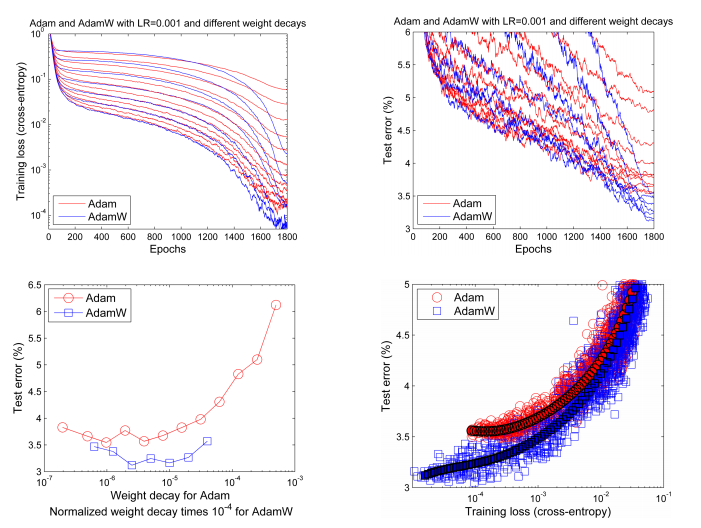


**Goal:** Compare the generalization capabilities of AdamW and Adam.
 - This figure shows the results for 12 settings of the L2 regularization of Adam and 7 settings of the normalized weight decay of AdamW
 - while the dynamics of the learning curves of Adam and AdamW often coincided for the first half
of the training run, AdamW often led to lower training loss and test errors
 - Importantly, the use of L2 weight decay in Adam did not yield as good results as decoupled weight decay in AdamW.
 - The results in the bottom right suggest that AdamW did not only yield better training loss but also yielded better generalization performance for similar training loss values.

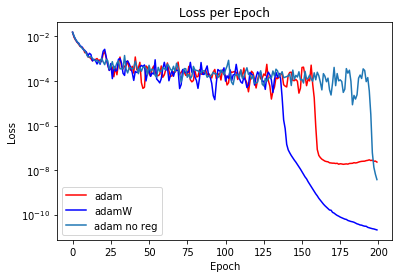

In [36]:
plt.plot(np.arange(200), loss_arr_adam, color='red', label="adam")
plt.plot(np.arange(200), loss_arr_adamW, color='blue', label="adamW")
plt.plot(np.arange(200), loss_adam, label="adam no reg")
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(np.arange(200), acc_arr_adam, color='red', label="adam")
plt.plot(np.arange(200), acc_arr_adamW, color='blue', label="adamW")
plt.plot(np.arange(200), acc_adam, label="adam no reg")
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

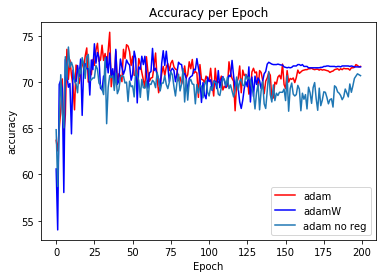

# Our results
 - Our results suggest that both Adam with both types of regularization lead to better generaliation than without.
 - We can also see that adamW is a small gap in the accuracy at the end of the training in favor to AdamW (~1%).
 - Regarding the loss, like in the paper, all three models had similar loss during most of the training but in the end AdamW yielded better results in terms of minimizing the loss.
 - We can also see that Adam with no regularization passes Adam with L2 at the very end of the training, suggesting that more epochs were needed to be certain about the conclusions.
 - we can see a drop in the loss function of all models in the following order - AdamW, Adam+L2 and Adam